# Hashtag Analysis and relationship with MMR graph data

In [13]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate
import json
import datetime
from datetime import timedelta
from collections import Counter
import re

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 3)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "6.HashtagAnalysis")
tweets_path = "../lib/GetOldTweets-python/out/completed"

In [115]:
# Import the biggest connected component to work on
FIn = snap.TFIn("../data/mmr_max_connected_component.bin")
graph = snap.TUNGraph.Load(FIn)

In [2]:
def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')

In [3]:
%%time
hashtag = "jesuischarlie"
hashtag_full = "#JeSuisCharlie"
tweets_filename = os.path.join(tweets_path,"tweets_#" + hashtag + "_2013-09-01_2016-12-31.json")
tweets = []
with open(tweets_filename) as fin:
    for line in read_large_file(fin):
        tweets.append(json.loads(line))
print("Imported %d tweets from %s" %(len(tweets),tweets_filename))

Imported 413857 tweets from ../lib/GetOldTweets-python/out/completed/tweets_#jesuischarlie_2013-09-01_2016-12-31.json
CPU times: user 12.5 s, sys: 944 ms, total: 13.5 s
Wall time: 13.5 s


Given the main graph, I have to identify the subgraph of nodes (usernames) that have been part of a Twitter conversation that involved the concerned hashtag. This means that I would consider node $i$ part of the subnet if one of the following occurs:
- $i$ has **tweeted** using hashtag $h$;
- $i$ has been **mentioned**/**replied to** by someone that used hashtag $h$;
- $i$ has tweeted a status that has been **retweeted**/**quoted** by someone else that used hashtag $h.$

Of course this operation is not immediate and trivial, since the usernames will be collected first as a set of actual Twitter screen names, which have to be mapped to their specific encoding afterwards. As a first example, I'm going to carry out the analysis by considering a single hashtag, then I'll extend the same analysis to multiple hashtags.

**#JeSuisCharlie** refers to the Charlie Hebdo shooting in France occurred on January 7th 2015, and by extension, a supporter of freedom of speech and resistance to armed threats. Some journalists embraced the expression as a rallying cry for the freedom of self-expression.

# 1. Extract Hashtag Subgraph
Let's collect all the usernames from the downloaded tweets and keep only the ones that are part of our MMR data.

In [52]:
def get_usernames_from_basic_tweet_info(hashtag, tweet):
    usernames = set()
    # (1): Has tweeted using hashtag
    if hashtag in [h.lower() for h in tweet["entities"]["hashtags"]]:
        usernames.add(tweet["user"]["screen_name"].lower())

    # (2): Has been mentioned / replied to
    if not tweet["in_reply_to_screen_name"] is None:
        usernames.add(tweet["in_reply_to_screen_name"].lower())
    for mentions in tweet["entities"]["user_mentions"]:
        usernames.add(mentions["screen_name"].lower())
    return usernames

def extract_hashtag_usernames(hashtag, tweets):
    hashtag_usernames = set()
    for tweet in tweets:
        hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet))
   
        # (3): Retweeted / Quoted status
        if "retweeted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["retweeted_status"]))
        if "quoted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["quoted_status"]))
    print("Total unique usernames involved in '#%s' hashtag conversations from %d tweets: %d" %(hashtag, len(tweets), len(hashtag_usernames)))
    return hashtag_usernames

In [53]:
hashtag_usernames = extract_hashtag_usernames(hashtag, tweets)

Total unique usernames involved in '#jesuischarlie' hashtag conversations from 413857 tweets: 224646


Let's now find the corresponding encoding for the usernames existing in the MMR graph data:

In [94]:
%%time
# First load all usernames in memory
usernames_to_id_dict = {}
with open("../data/usernames.csv") as usernames_f:
    for line in read_large_file(usernames_f):
        username = line.split(',')[0]
        encoding = int(line.split(',')[1])
        usernames_to_id_dict[username] = encoding

CPU times: user 2min 15s, sys: 7.31 s, total: 2min 22s
Wall time: 2min 22s


In [96]:
%%time
# Filter usernames
usernames_to_id_dict = { k:v for k,v in usernames_to_id_dict.iteritems() if k in hashtag_usernames }

CPU times: user 24.6 s, sys: 464 ms, total: 25.1 s
Wall time: 24.6 s


At this point, all the values of the `usernames_to_id_dict` represent node IDs in the MMR graph so it's trivial to extract the subnet of nodes having some IDs:

In [118]:
# Get subgraph
NIdV = snap.TIntV()
for node_id in usernames_to_id_dict.itervalues():
    NIdV.Add(node_id)
hashtag_subgraph = snap.GetSubGraph(graph, NIdV)

Let's show some summary statistics:

In [149]:
tab_format = "{0: <65} {1}"
print(tab_format.format("Total Tweets for hashtag '%s': " %hashtag, len(tweets)))
print(tab_format.format("Total unique usernames found in tweets: ", len(hashtag_usernames)))
print(tab_format.format("Total usernames within ORIGINAL MMR data: ", str(len(usernames_to_id_dict)) + " (%2.f%% of %d)" %(len(usernames_to_id_dict)*100.0/len(hashtag_usernames), len(hashtag_usernames))))
print(tab_format.format("Total usernames within CLEANED MMR data and biggest component: ", str(hashtag_subgraph.GetNodes()) + " (%.2f%% of %d)" %(hashtag_subgraph.GetNodes()*100.0/len(usernames_to_id_dict), len(usernames_to_id_dict))))
print(tab_format.format("Size of subgraph compared to full graph: ", "%.2f%%" %(hashtag_subgraph.GetNodes()*100.0/graph.GetNodes())))

Total Tweets for hashtag 'jesuischarlie':                         413857
Total unique usernames found in tweets:                           224646
Total usernames within ORIGINAL MMR data:                         132318 (59% of 224646)
Total usernames within CLEANED MMR data and biggest component:    130173 (98.38% of 132318)
Size of subgraph compared to full graph:                          0.15%


Overall, **59%** of the users who tweeted about **#JeSuisCharlie** have been captured by the MMR graph data (*potentially available hashtag data*). **98,38%** of usernames in the potentially available hashtag data are part of the cleaned data and the largest connected component. This means that the cleanup process from the previous chapters didn't significantly impact the amount of available data. Furthermore, the amount of nodes the are going to be analyzed from now on represent the **0,15%** of the global MMR data.

# 2. Temporal Frequency Distribution of the hashtag
As a first step of the hashtag analysis, we first want to do some basic processing on the downloaded tweets and figure out how much the utilization of such hashtag is spread throughout the time-window we're focusing on (September 2013 - December 2019).

In [320]:
def get_tweet_users(tweet):
    users = set()
    users.add(tweet["user"]["screen_name"].lower())
    if not tweet["in_reply_to_screen_name"] is None:
        users.add(tweet["in_reply_to_screen_name"].lower())
    for mention in tweet["entities"]["user_mentions"]:
        users.add(mention["screen_name"].lower())
    if "retweeted_status" in tweet:
        users.update(get_tweet_users(tweet["retweeted_status"]))
    if "quoted_status" in tweet:
        users.update(get_tweet_users(tweet["quoted_status"]))
    return users

def collect_tweets_dates(tweets, graph_usernames):
    all_dates = []
    subgraph_dates = []
    graph_usernames_set = set(graph_usernames) # Membership check is much faster for sets than lists
    print("Collecting tweets dates...")
    for tweet in tweets:
        date = datetime.datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y').date()
        all_dates.append(date)
        if any([username in graph_usernames_set for username in get_tweet_users(tweet)]):
            subgraph_dates.append(date)
    print("Done! Total dates: %d\nSubgraph dates: %d" %(len(all_dates), len(subgraph_dates)))
    return all_dates, subgraph_dates

def plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(9,5)
    fig.set_dpi(100)
    mpl_data1 = mdates.date2num(all_tweets_dates)
    mpl_data2 = mdates.date2num(subgraph_tweets_dates)
    ax.hist([mpl_data1, mpl_data2], label=["All Users", "Only MMR Users"], align="mid", rwidth=0.5)
    
    # Set legend
    ax.legend(loc="upper right")
    
    # Axes labels
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_xlabel("Periods", fontsize=12, fontweight="bold")
    
    # Axes ticks and formatting
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    plt.xticks(rotation="20",fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.title("%s Hashtag Frequency Distribution over the years" %hashtag)
    plt.savefig(os.path.join(pictures_path,hashtag+"_Frequency_Distribution.png"))
    fig.set_tight_layout(False)
    plt.show()

In [254]:
%%time
# Collect tweets dates
all_tweets_dates, subgraph_tweets_dates = collect_tweets_dates(tweets, usernames_to_id_dict.keys())

Done! Total dates: 413857
Subgraph dates: 221892
CPU times: user 7.76 s, sys: 16 ms, total: 7.77 s
Wall time: 7.76 s


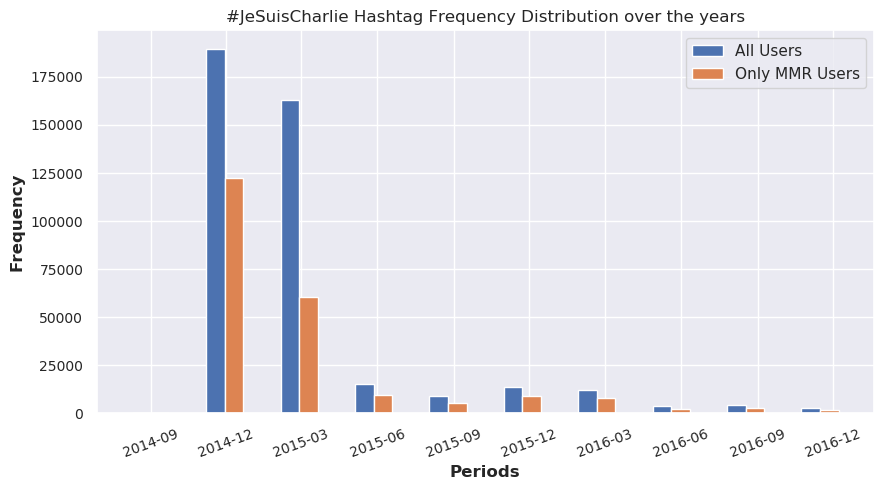

In [321]:
# Plot hashtag frequency distribution
plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag_full)

The **#JeSuisCharlie** hashtag doesn't have a really steady frequency distribution over the years in the timeframe we're considering, as it can be seen from the plot above. Indeed, the great majority of the tweets have been published in the first 5 months of 2015, as expected, since the events related to the spread of the hashtags occurred in January 2015. The overall peak has been reached on January 9th, 2015, with **95777** tweets published. The histogram that only considers the MMR users, as expected, follows pretty much the same distribution as the overall one: the peak values are lower but the height difference between the bars seems to be almost identical and the peak value is **61561**, reached on January 10th, 2015.

# 3. Subgraph Metric Analysis

In [323]:
hashtag_subgraph.GetNodes()

130173

In [324]:
hashtag_subgraph.GetEdges()

580518

In [325]:
scc = snap.GetMxScc(hashtag_subgraph)

In [327]:
scc.GetNodes()

80374

In [328]:
scc.GetEdges()

578202